In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import cupy as cp
device = 'gpu'

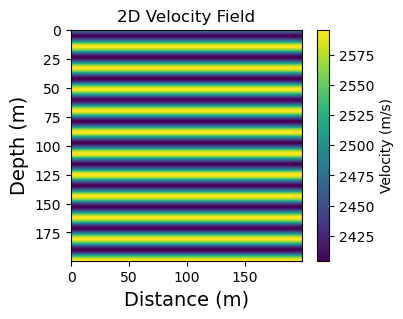

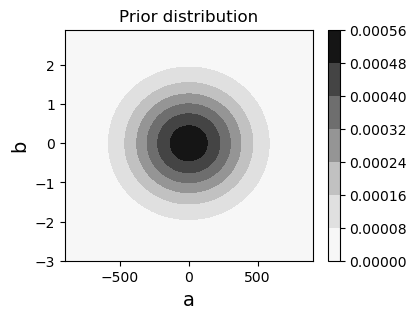

In [66]:
labelsize=14
from scipy.stats import multivariate_normal
mu_a, std_a = 0, 300
mu_b, std_b = 0, 1
# Define the mean and covariance matrix
mu = np.array([mu_a, mu_b])
cov = np.array([[std_a**2, 0], [0, std_b**2]])
Q = np.linalg.inv(cov)

a = np.random.normal(mu_a, std_a)
b = np.random.normal(mu_b, std_b)

x, z = np.meshgrid(np.arange(200), np.arange(200))
v = 2500 + a * np.sin(0.5*z*b)
# v += 100 * np.sin(0.02*x) * np.sin(0.05*z)
# v += 50 * np.cos(0.03*x) * np.sin(0.06*z)
# v += 80 * np.sin(0.05*x) * np.sin(0.04*z)
# v += 20 * np.cos(0.02*x) * np.sin(0.07*z)
# v += 40 * np.sin(0.06*x) * np.sin(0.03*z)
# v = 2500 + a + z * b**2

plt.figure(figsize=(4,3))
plt.imshow(v)
plt.title("2D Velocity Field")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.show()

# Create a grid of points to evaluate the distribution at
# x, y = np.mgrid[-3:3:.1, -3:3:.1]
xx, yy = np.mgrid[mu_a-3*std_a:mu_a+3*std_a:.1, mu_b-3*std_b:mu_b+3*std_b:.1]
pos = np.dstack((xx, yy))

# Evaluate the distribution at each point in the grid
rv = multivariate_normal(mu, cov)
zz = rv.pdf(pos)

# Plot the distribution
plt.figure(figsize=(4,3))
plt.contourf(xx, yy, zz, cmap='Greys')
plt.title("Prior distribution")
plt.xlabel('a', fontsize=labelsize)
plt.ylabel('b', fontsize=labelsize)
plt.colorbar()
plt.show()

In [67]:
# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

v_ref = v

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 2 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)

print("Number of receivers:", zxrec.shape[1])
# # Propagajtion
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
print("shape of p(z,x,t) =", p.shape)
d_obs = p[zxrec[0], zxrec[1], :]


plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[az[0], az[-1],at[0], at[-1]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 392


In [65]:
# Set initial velocity guess
# v_init = 2500 + mu_a * np.sin(0.5*z*mu_b)
# v_init = np.zeros([nz, nx]) + 2500

# Display initial gradiant
'''plt.figure(figsize=(3,3))
g_adj = gradiant(v_init,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device='cpu').reshape(nz,nz)
plt.imshow(g_adj)
plt.colorbar() 
plt.title("Adjoint State gradiant")'''

mu = 2500
# alpha = 0.01 # Regularization parameter
alpha = 10

# Define cost function
def cost(B,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	# J: Prior part
	vel = 2500 + B[0] * np.sin(0.5*z*B[1])
	print(np.mean(vel))
	L2 = J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("L2 loss = %.4f " % L2, end='')
	# Q: Likelihood part
	penalty = .5 * B.T.dot(Q).dot(B) * alpha
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = L2 + penalty
	print("Total loss = %.4f " % loss)
	global current_loss
	current_loss = np.array([L2,penalty,loss])
	return loss

def gradiant(B,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	vel = 2500 + B[0] * np.sin(0.5*z*B[1])
	nz, nx, nt = len(az), len(ax), len(at)
	if vel.ndim == 1: vel = np.reshape(vel,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,vel,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	dv_da = np.sin(0.5 * z * B[1])
	dv_db = 0.5 * B[0] * z * np.cos(0.5 * z * B[1])
	dJ_dB = np.array([np.sum(dJ_dv * dv_da), np.sum(dJ_dv * dv_db)])
	print(dJ_dB)

	# return dJ_dv.flatten()
	return dJ_dB + Q.dot(B) * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	global B_tracker
	B_tracker = np.vstack([B_tracker,xk])

# Set the initial starting point
alpha = 10
a_init, b_init = np.random.normal(mu_a, std_a), np.random.normal(mu_b, std_b)
a_init, b_init = 1, 0.01
B_init = np.array([a_init, b_init])
v_init = 2500 + B_init[0] * np.sin(0.5*z*B_init[1])

# minimize cost function
loss_tracker = np.empty((0,3))
B_tracker = np.array([a_init, b_init])

start = time.time()
resi = minimize(fun = cost, 
               x0 = B_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
            #    method='Newton-CG',
            #    bounds = np.full((len(B_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant,
               options = {'disp':True, 'maxiter':200},
			   callback=callback
              )
# v_fwi = np.reshape(resi.x,(nz,nx))
a_fwi, b_fwi = resi.x[0], resi.x[1]
v_fwi = 2500 + a_fwi * np.sin(0.5*z*b_fwi)
print(v_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

2500.4575930589663
L2 loss = 958.4578 Penalty term = 0.0006 Total loss = 958.4583 
[ 10.54721084 925.34033358]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58458D+02    |proj g|=  9.25440D+02
2499.988074077026


 This problem is unconstrained.


L2 loss = 945.3175 Penalty term = 4.8999 Total loss = 950.2174 
[-2.90056156 78.06121167]

At iterate    1    f=  9.50217D+02    |proj g|=  6.81619D+01
2500.000247456438
L2 loss = 944.9306 Penalty term = 5.7188 Total loss = 950.6493 
[-3.29413442  9.52309843]
2499.999048305808
L2 loss = 944.4454 Penalty term = 5.1305 Total loss = 949.5759 
[ -3.85087404 -16.51087516]

At iterate    2    f=  9.49576D+02    |proj g|=  2.66405D+01
2500.000231197962
L2 loss = 944.3890 Penalty term = 5.0657 Total loss = 949.4547 
[-3.85353503 17.36244569]

At iterate    3    f=  9.49455D+02    |proj g|=  7.29703D+00
2500.000313718027
L2 loss = 944.3784 Penalty term = 5.0789 Total loss = 949.4573 
[-3.87129639  9.873557  ]
2500.0002634566954
L2 loss = 944.3858 Penalty term = 5.0685 Total loss = 949.4543 
[-3.85821476 15.7343916 ]

At iterate    4    f=  9.49454D+02    |proj g|=  5.66614D+00
2500.0003092546276
L2 loss = 944.3737 Penalty term = 5.0818 Total loss = 949.4556 
[-3.87381884  8.25465507]
2500.00029


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


L2 loss = 921.9597 Penalty term = 3886.3219 Total loss = 4808.2816 
[  -0.58618078 -197.93072399]
2498.409782724624
L2 loss = 737.1087 Penalty term = 11.7355 Total loss = 748.8442 
[  0.47791305 340.14713609]
2499.3068988882724
L2 loss = 746.3026 Penalty term = 36.4181 Total loss = 782.7207 
[ -1.5535699  -46.70808152]
2498.8343381211316
L2 loss = 700.6857 Penalty term = 17.9757 Total loss = 718.6614 
[ -1.18273756 -76.59098299]
2498.753472368745
L2 loss = 700.0058 Penalty term = 15.7187 Total loss = 715.7245 
[ -0.91426605 -41.47532199]
2499.4640336910866
L2 loss = 707.3966 Penalty term = 13.0203 Total loss = 720.4169 
[-1.99810686e-02  8.76835532e+02]
2499.7948873343494
L2 loss = 693.4899 Penalty term = 14.3809 Total loss = 707.8708 
[-0.80528579 61.29875397]

At iterate   16    f=  7.07871D+02    |proj g|=  4.48347D+01
2499.768417895453
L2 loss = 713.5400 Penalty term = 27.7211 Total loss = 741.2611 
[ -1.3003095  139.34078858]
2499.8231699614025
L2 loss = 688.9116 Penalty term = 15


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


L2 loss = 829.2923 Penalty term = 190924.7650 Total loss = 191754.0573 
[ -1.19684651 -79.90313685]
2500.1055053245195
L2 loss = 768.8073 Penalty term = 1306.7894 Total loss = 2075.5968 
[-1.37284634 55.8498191 ]
2500.197538873965
L2 loss = 795.6073 Penalty term = 106.5589 Total loss = 902.1662 
[-1.2154105  54.60225543]
2499.6628920545627
L2 loss = 709.9823 Penalty term = 26.2404 Total loss = 736.2227 
[ -1.27303066 153.11903879]
2498.7467730259036
L2 loss = 698.6028 Penalty term = 16.8507 Total loss = 715.4535 
[ -1.04432018 -37.30992238]
2499.5824376729092
L2 loss = 694.2095 Penalty term = 15.4988 Total loss = 709.7083 
[ -1.02734424 -56.71026955]
2500.057551823797
L2 loss = 684.5834 Penalty term = 15.3153 Total loss = 699.8987 
[ -0.9111115  199.64434292]
2500.0607756025306
L2 loss = 684.5526 Penalty term = 15.3098 Total loss = 699.8624 
[ -0.9049626  209.34760049]
2500.0611156314426
L2 loss = 684.5501 Penalty term = 15.3091 Total loss = 699.8591 
[ -0.90420393 210.53714801]
2500.0


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


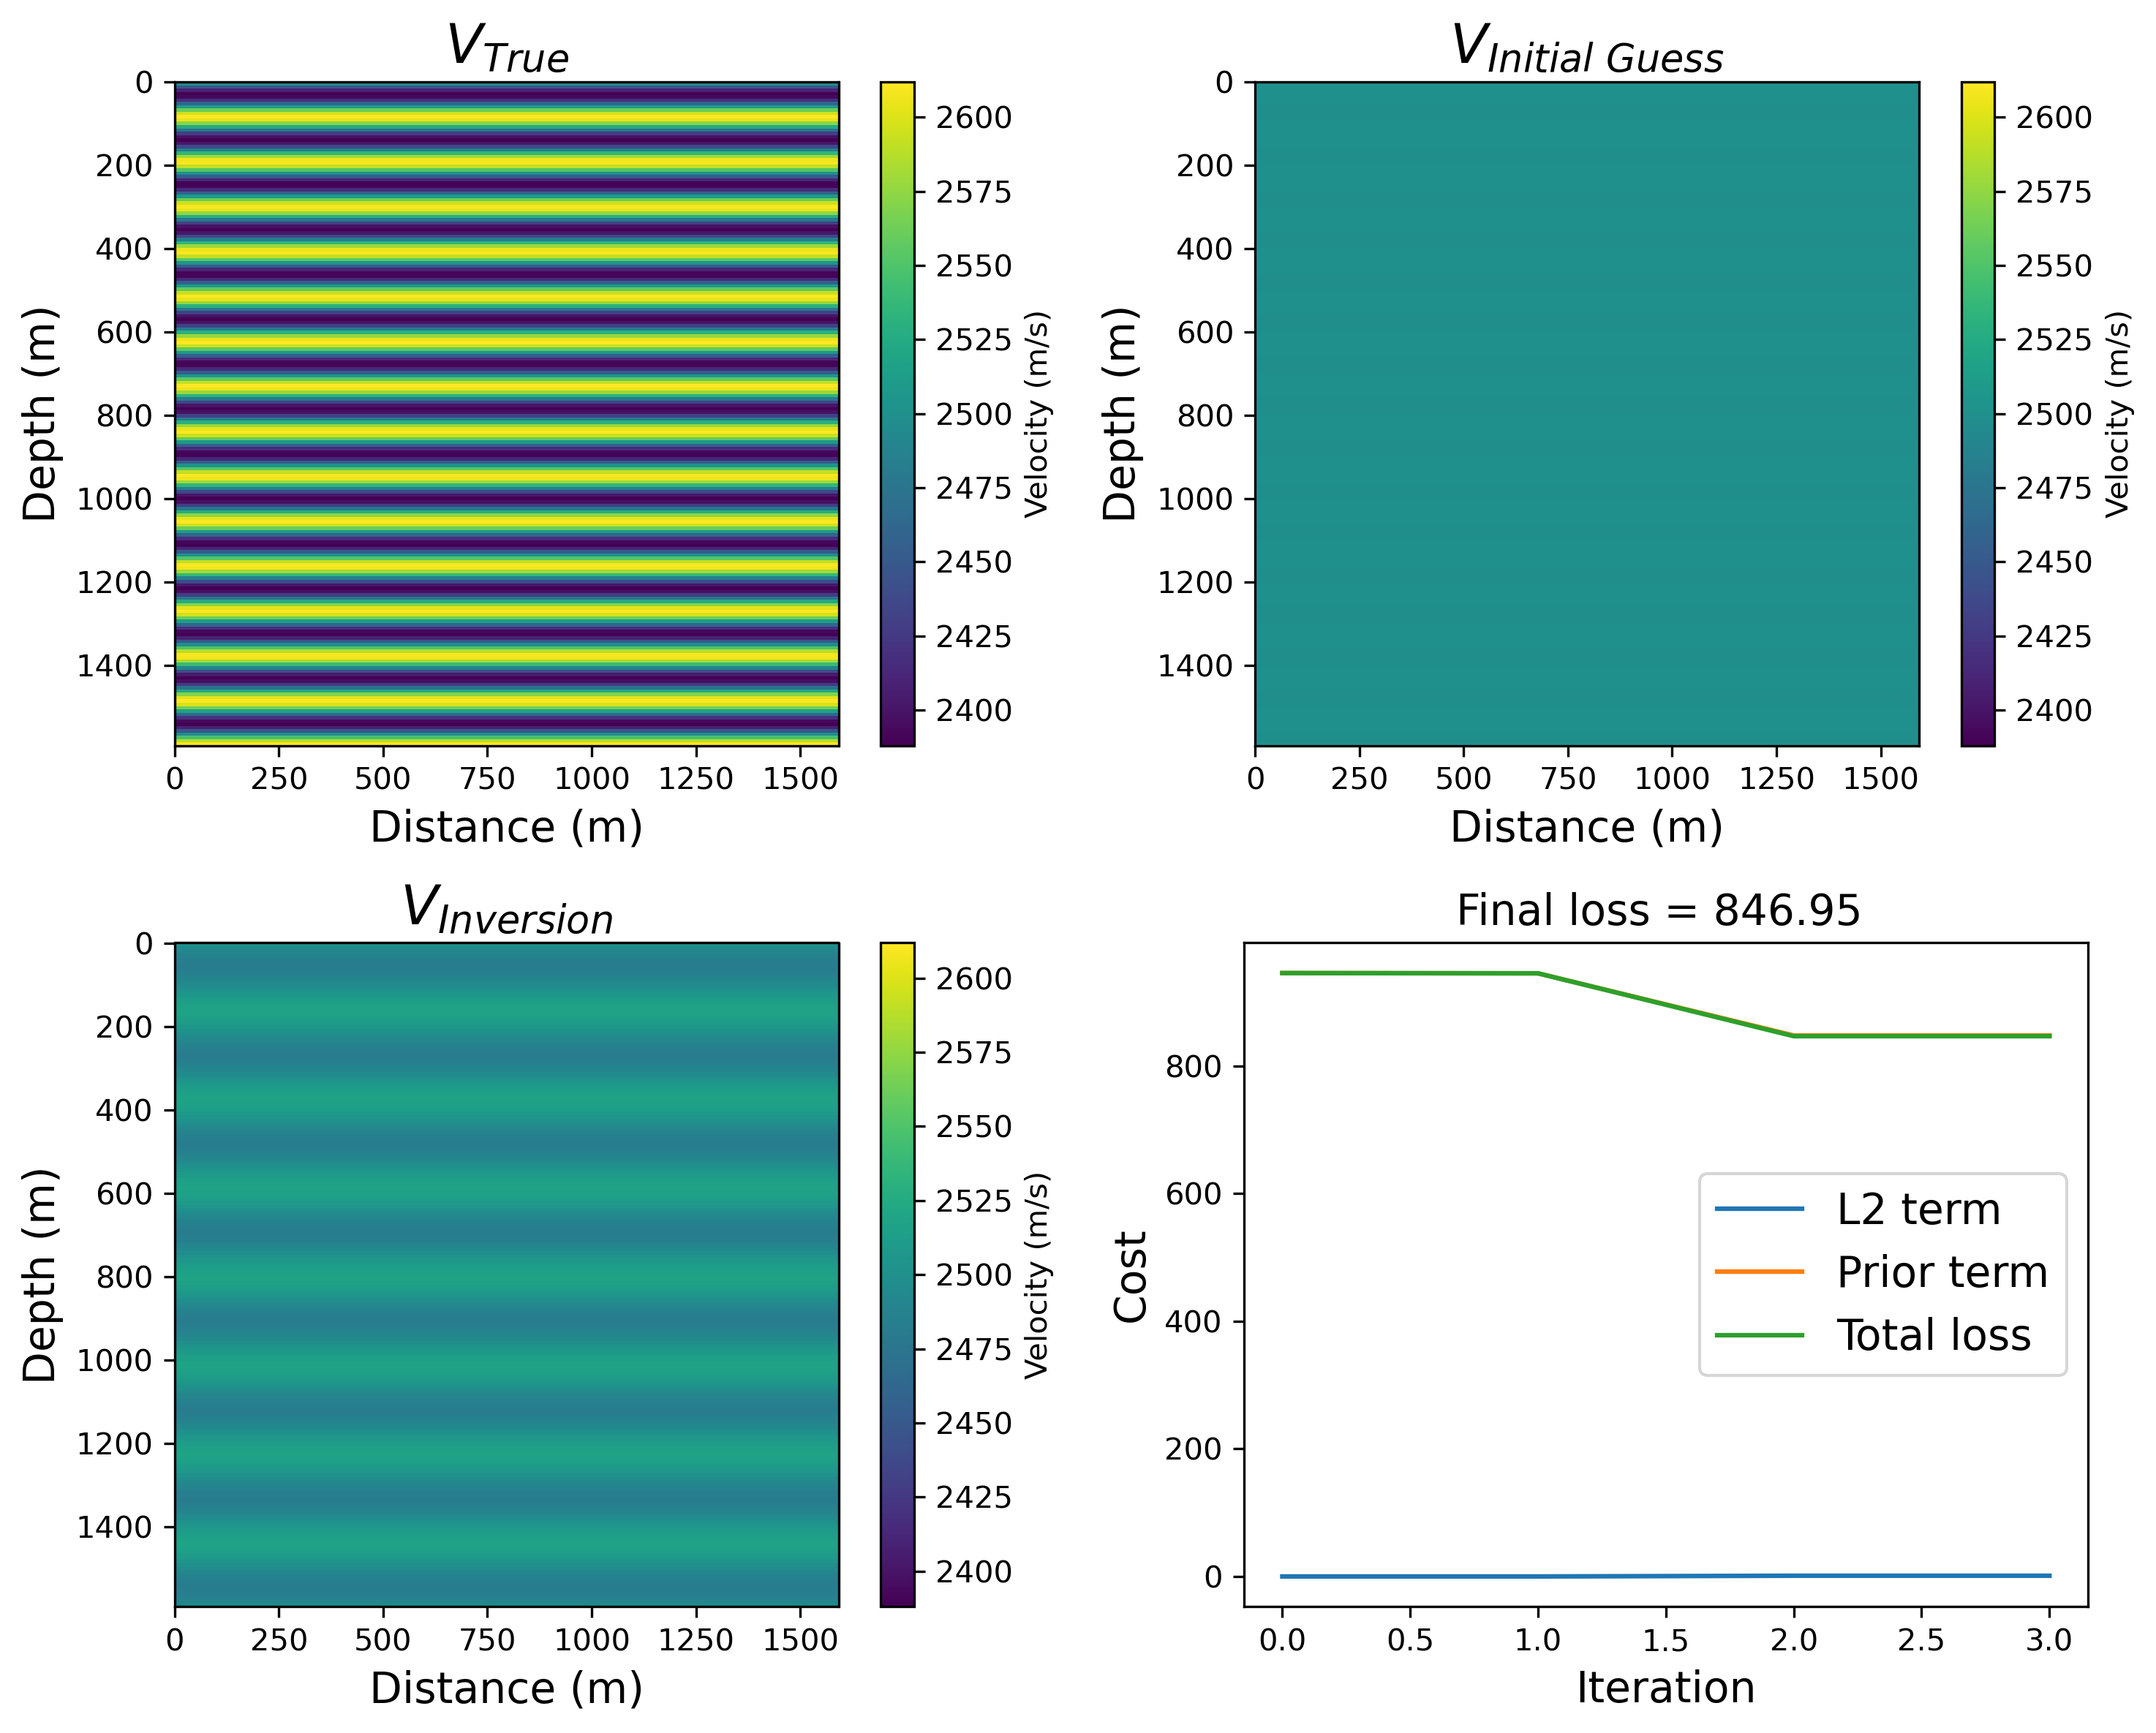

<Figure size 640x480 with 0 Axes>

In [63]:
vmini, vmaxi = np.min(v_ref), np.max(v_ref)
plt.figure(figsize=(10,8),dpi=300)
# plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref,vmin=vmini,vmax=vmaxi,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init,vmin=vmini,vmax=vmaxi,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(v_fwi,vmin=vmini,vmax=vmaxi,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)

plt.subplot(2,2,4)
plt.title("Final loss = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="L2 term")
plt.plot(loss_tracker[:,2],label="Prior term")
plt.plot(loss_tracker[:,0],label="Total loss")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,1500)
plt.legend(fontsize=labelsize)
plt.tight_layout()
plt.show()
plt.tight_layout()

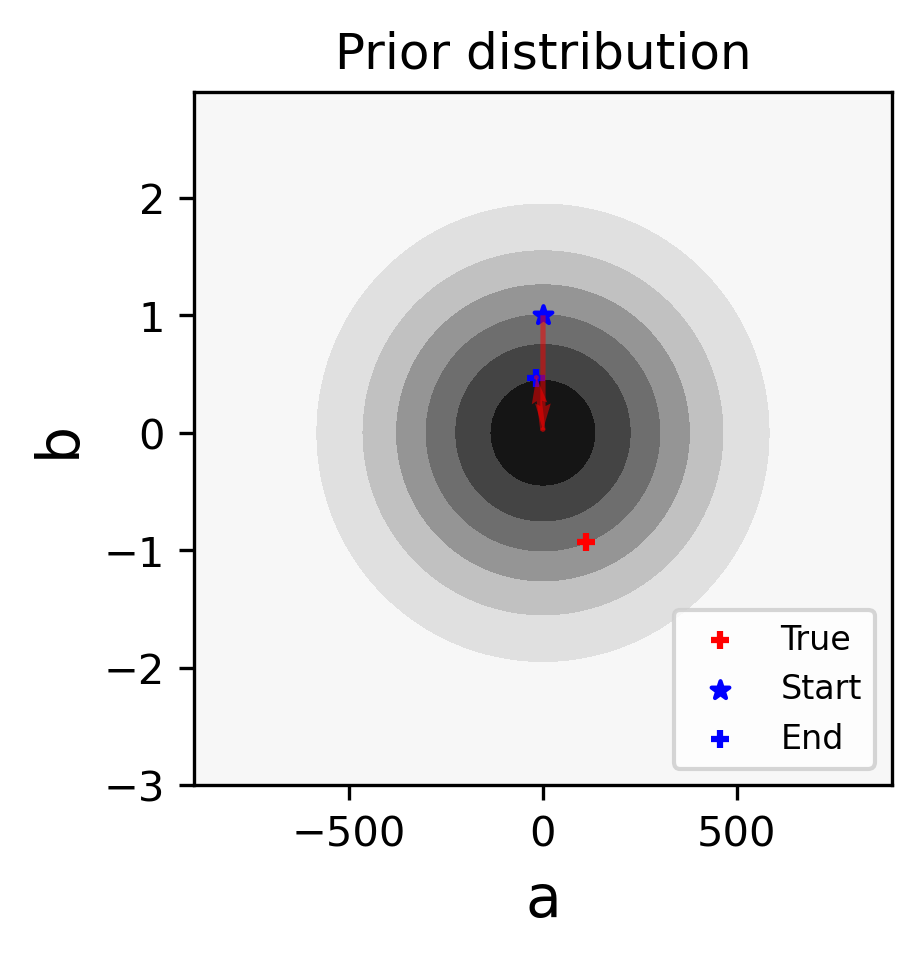

In [64]:
# Plot the distribution
plt.figure(figsize=(3,3),dpi=300)
plt.contourf(xx, yy, zz, cmap='Greys')
plt.scatter(a,b,marker='+',color='r',s=20,label='True')
plt.scatter(a_init,b_init,marker='*',color='blue',s=20,label='Start')
plt.scatter(resi.x[0],resi.x[1],marker='+',color='blue',s=20,label='End')
# plt.plot(B_tracker[:,0],B_tracker[:,1],'r',lw=1,alpha=0.5)
plt.quiver(B_tracker[:-1,0],B_tracker[:-1,1], B_tracker[1:,0]-B_tracker[:-1,0],\
        B_tracker[1:,1]-B_tracker[:-1,1], scale_units='xy',angles='xy', \
        scale=1, color='r',alpha=0.5)

plt.title("Prior distribution")
plt.xlabel('a', fontsize=labelsize)
plt.ylabel('b', fontsize=labelsize)
plt.legend(loc=4,prop={'size': 8})
plt.show()

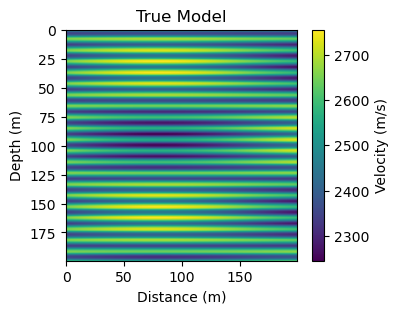

In [43]:
import numpy as np

# Define the prior distribution
mu_a, std_a = 0, 300
mu_b, std_b = 0, 1

# Sample values for the true model from the prior distribution
a_true = np.random.normal(mu_a, std_a)
b_true = np.random.normal(mu_b, std_b)

# Create a velocity model with sinusoidal perturbations
x, z = np.meshgrid(np.arange(200), np.arange(200))
v0 = 2500
v = v0 + a_true * np.sin(0.5*z*b_true)
v += 100 * np.sin(0.02*x) * np.sin(0.05*z)
# v += 50 * np.cos(0.03*x) * np.sin(0.06*z)
# v += 80 * np.sin(0.05*x) * np.sin(0.04*z)
# v += 20 * np.cos(0.02*x) * np.sin(0.07*z)
# v += 40 * np.sin(0.06*x) * np.sin(0.03*z)

# Show the true model
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.imshow(v)
plt.title("True Model")
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.show()
